In [5]:
# Calculates the eikonal depth of a non-uniform density on a cylinder

import numpy as np
import scipy as sp
from numpy import linalg as la
import math

import os

import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=16)   
plt.rc('ytick', labelsize=16) 
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

N=64
ratio=4
#n=(N+1)**2
n=(N+1+2*ratio)**2

thickness=ratio/N

x=2*np.pi*np.random.rand(n)#np.linspace(-thickness,1+thickness,N+1+2*ratio)
y=-thickness+(1+2*thickness)*np.random.rand(n)

theta_z=np.empty((n,2))
for i in range(n):
    theta_z[i,0]=x[i]
    theta_z[i,1]=y[i]

#Find points that are in the boundary region
in_boundary = 1*(theta_z[:,1]<=0)+1*(theta_z[:,1]>=1)
in_boundary = 1*(in_boundary>0)

nEffective=n-len(np.nonzero(in_boundary))

points=np.empty((n,3))
points[:,0]=np.cos(theta_z[:,0])
points[:,1]=np.sin(theta_z[:,0])
points[:,2]=theta_z[:,1]

F=np.zeros((n,1))
f=np.ones((n,1))

f=(1-.9*np.sin(-np.pi/2+0.5*np.pi*points[:,2] + 3*theta_z[:,0])**2)
for i in range(n):
    F[i]=1/f[i]
F[np.nonzero(in_boundary)]=0

# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
# # Creating plot
# sctt = ax.scatter3D(points[:,0], points[:,1], points[:,2], c=f, cmap='hot')
# theta=np.linspace(0,2*np.pi,20)
# zeta=np.linspace(0,1,10)
# Theta, Zeta=np.meshgrid(theta, zeta)
# fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('density_cylinder.pdf', dpi=300)

In [6]:
from scipy.spatial.distance import pdist,squareform

from sklearn.neighbors import radius_neighbors_graph

# Cut-off for the neighborhood graph
radius=2*ratio/N
sigma=0.2

sparse_graph = radius_neighbors_graph(points, radius, mode='connectivity',include_self=True)

dist_mat = radius_neighbors_graph(points, radius, mode='distance',include_self=True)
wght_mat=dist_mat
wght_mat.data=100*np.exp(-dist_mat.data**2/(2*sigma**2*radius**2))/(np.pi*nEffective*radius**4*sigma**4)

print('Minimum number of neighbors')
print(np.min(np.sum(1*(sparse_graph>0),axis=1)))
print('Maximum number of neighbors')
print(np.max(np.sum(1*(sparse_graph>0),axis=1)))

Minimum number of neighbors
9
Maximum number of neighbors
60


In [7]:
values = 100*np.ones(n)

#Initialize the solved set/list/values
solved_list = np.nonzero(in_boundary)[0]
solved_set = set(solved_list)
values[solved_list] = 0.

max_solved = 0.

from scipy.sparse import find


#Initialize the considered set
considered_set = set()
for i in solved_list:
    neighbors = set(find(sparse_graph[i,:])[1])
    considered_set = considered_set.union(neighbors.difference(solved_set))
update_set = considered_set

#Create a list so that neighbor_set_list[i] = {Neighbors of i}
neighbor_set_list = []
for i in range(n):
    neighbor_set_list.append(set(find(sparse_graph[i,:])[1]))
k = len(solved_set)


while considered_set:
    
    #This is just a progress indicator
    if k%100 == 0:
        print("{:.2f} %".format(k/n*100),end='\r')
    k += 1
    

    for i in update_set:
        neighbors = neighbor_set_list[i]
        solved_neighbors = list(neighbors.intersection(solved_set))  
        neighbor_weights = wght_mat[i,solved_neighbors].toarray()[0]
        neighbor_values = values[solved_neighbors]
            
            
        values[i] = (neighbor_values.dot(neighbor_weights) + np.sqrt(neighbor_values.dot(neighbor_weights)**2 - np.sum(neighbor_weights)*((neighbor_values**2).dot(neighbor_weights) - 1/F[i]**2)))/np.sum(neighbor_weights)
    
    #Here we use update set to track places in the considered set where values need to be updates (i.e. there is a new solved neighbor)
    l = list(considered_set)
    min_index = l[np.argmin(values[l])]
    solved_set.add(min_index)
    solved_list = list(solved_set)
    considered_set.remove(min_index)
    update_set = neighbor_set_list[min_index].difference(solved_set)
    considered_set = considered_set.union(update_set)


print("Calculations complete")

/tmp/ipykernel_2900/640732998.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  values[i] = (neighbor_values.dot(neighbor_weights) + np.sqrt(neighbor_values.dot(neighbor_weights)**2 - np.sum(neighbor_weights)*((neighbor_values**2).dot(neighbor_weights) - 1/F[i]**2)))/np.sum(neighbor_weights)


Calculations complete


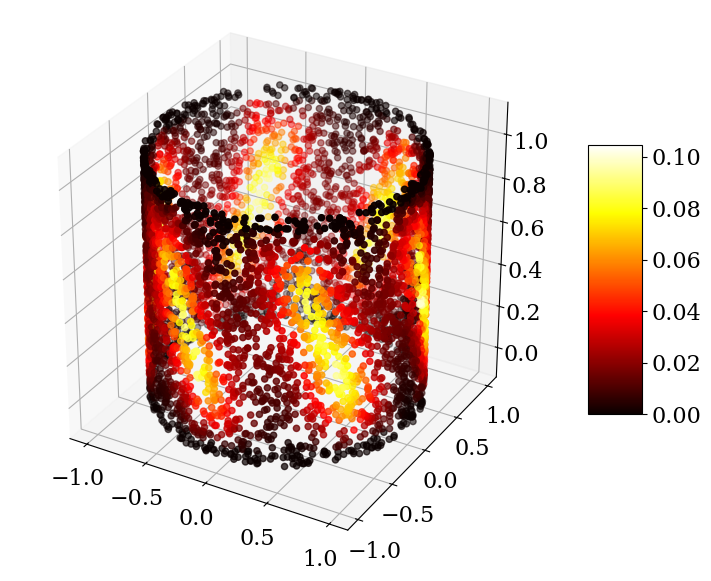

In [8]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
sctt=ax.scatter(points[:,0], points[:,1], points[:,2], c=values, cmap='hot')
#plt.title("simple 3D scatter plot")
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
#plt.tight_layout()
ax.set_box_aspect([1,1,1])
plt.savefig('depth_cylinder.jpg', dpi=300, bbox_inches='tight')
# show plot
plt.show()